# В данном ноутбуке решаем задачу детекции дефектов на транспортерной ленте
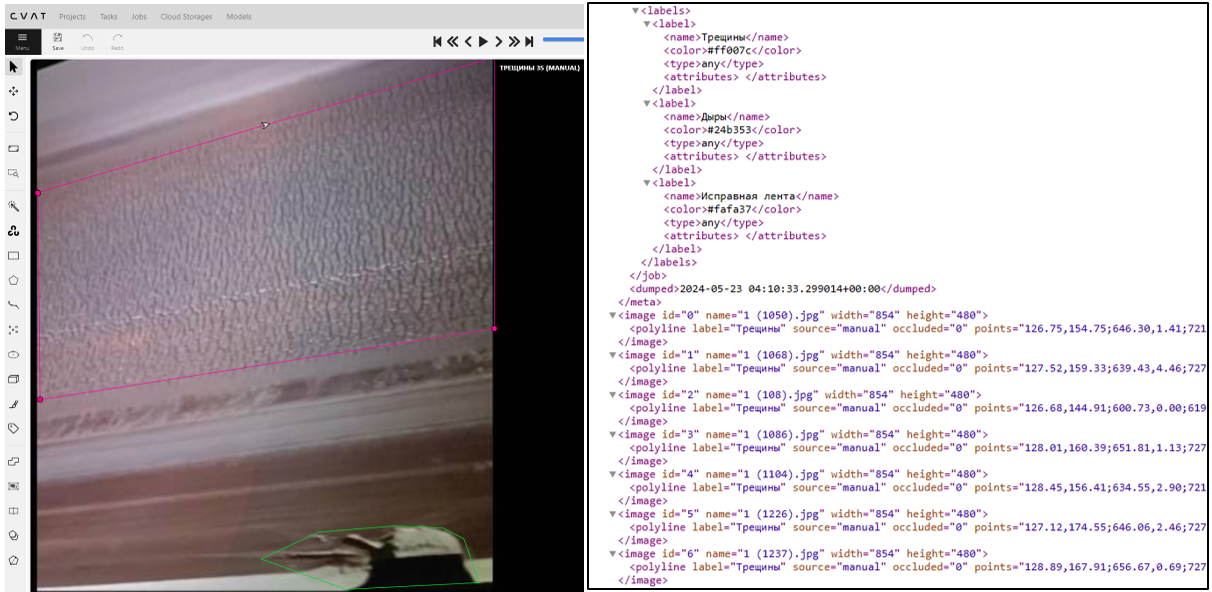

Импортируем необходимые библиотеки

In [21]:
# Импорты
import os
import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

Загружаем предварительно созданный датафрейм с разметкой изображений и сами изображения

In [2]:
# Путь к изображениям
img_path = '/content/images'
# Загрузка DataFrame с аннотациями
df = pd.read_csv('/content/new_annotations.csv')
#df = pd.read_csv('/content/df.csv')


In [5]:
print(df.head(3))

      filename  width  height  class        xmin        ymin        xmax  \
0  2 (112).jpg    600     337      0  355.166276  124.353000  377.339578   
1  2 (112).jpg    600     337      1   89.030445   27.416354  385.538642   
2  2 (112).jpg    600     337      2  356.522248    0.842500  507.786885   

         ymax  
0  163.599458  
1  320.571250  
2  336.859583  


Определяем функцию для создания модели детекции

In [6]:
# Функция для получения модели обнаружения объектов
def get_object_detection_model(num_classes):
    backbone = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    backbone = create_feature_extractor(backbone, return_nodes={"layer4": "0"})
    backbone.out_channels = 2048

    rpn_anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),)
    )

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=["0"], output_size=7, sampling_ratio=2
    )

    model = FasterRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=rpn_anchor_generator,
        box_roi_pool=roi_pooler,
    )

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

Создаем пользовательский датасет для его дальнейшей обработки моделью и Создаем классы необходимых трансформаций

In [7]:
# Пользовательский набор данных
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, df, transforms=None):
        self.root = root
        self.transforms = transforms
        self.dataframe = df
        self.imgs = list(self.dataframe['filename'].unique())

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = os.path.join(self.root, img_name)
        img = Image.open(img_path).convert("RGB")

        # Получение текущих аннотаций
        current_annotations = self.dataframe[self.dataframe['filename'] == img_name]
        num_objs = len(current_annotations)

        boxes = []
        labels = []
        for _, row in current_annotations.iterrows():
            boxes.append([row["xmin"], row["ymin"], row["xmax"], row["ymax"]])
            labels.append(row["class"])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels, "image_id": image_id, "area": area, "iscrowd": iscrowd}

        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [8]:
# Классы преобразований
class ComposeTransforms(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for transform in self.transforms:
            image, target = transform(image, target)
        return image, target

class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

class CustomRandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, target):
        if torch.rand(1).item() < self.p:
            image = F.hflip(image)
            if "boxes" in target:
                bbox = target["boxes"]
                image_width = image.shape[2]  # Assuming image shape is [C, H, W]
                bbox[:, [0, 2]] = image_width - bbox[:, [2, 0]]
                target["boxes"] = bbox
        return image, target

def get_transform(train):
    transforms = []
    transforms.append(ToTensor())
    if train:
        transforms.append(CustomRandomHorizontalFlip(0.5))
    return ComposeTransforms(transforms)

Напишем функцию для обработки батчей в DataLoader

In [9]:
# Определение функции collate_fn
def collate_fn(batch):
    return tuple(zip(*batch))

Определим функцию обучения модели детекции

In [10]:
# Обучение модели
def train_model(num_classes, num_epochs, batch_size):
    dataset = CustomDataset(img_path, df, transforms=get_transform(train=True))
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True, num_workers=1, collate_fn=collate_fn
    )

    model = get_object_detection_model(num_classes)
    model = model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    for epoch in range(num_epochs):
        model.train()
        i = 0
        for images, targets in tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())

            losses.backward()
            optimizer.step()

            if i % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(data_loader)}], Loss: {losses.item():.4f}")
            i += 1

        lr_scheduler.step()

    return model

И функцию проверки модели на валидационных данных и визуализации предсказаний

In [19]:
# Визуализация предсказаний
def visualize_predictions(image, boxes, labels, scores, threshold=0.5):
    image = image.permute(1, 2, 0).cpu().numpy()
    image = np.clip(image, 0, 1)
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            xmin, ymin, xmax, ymax = box
            rect = plt.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=2
            )
            ax.add_patch(rect)
            label_text = f"{label}: {score:.2f}"
            ax.text(xmin, ymin, label_text, bbox={"facecolor": "yellow", "alpha": 0.5})

    plt.show()

# Проверка модели на валидационных данных
def evaluate_model(model, data_loader_test):
    model.eval()
    with torch.no_grad():
        # Получаем все батчи
        all_batches = list(data_loader_test)

        # Выбираем случайный батч
        random_batch = random.choice(all_batches)
        images, targets = random_batch

        images = list(img.to(device) for img in images)
        outputs = model(images)

        # Выбираем случайное изображение внутри выбранного батча
        random_index = random.randint(0, len(images) - 1)
        img = images[random_index]
        output = outputs[random_index]

        boxes = output["boxes"].cpu().numpy()
        labels = output["labels"].cpu().numpy()
        scores = output["scores"].cpu().numpy()

        # Визуализируем выбранное изображение
        visualize_predictions(img, boxes, labels, scores)

In [11]:
# Проверка модели на валидационных данных
def evaluate_model(model, data_loader_test):
    model.eval()
    with torch.no_grad():
        for images, targets in data_loader_test:
            images = list(img.to(device) for img in images)
            outputs = model(images)

            for img, output in zip(images, outputs):
                boxes = output["boxes"].cpu().numpy()
                labels = output["labels"].cpu().numpy()
                scores = output["scores"].cpu().numpy()
                visualize_predictions(img, boxes, labels, scores)

In [12]:
# Визуализация предсказаний
def visualize_predictions(image, boxes, labels, scores, threshold=0.5):
    image = image.permute(1, 2, 0).cpu().numpy()
    image = np.clip(image, 0, 1)
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            xmin, ymin, xmax, ymax = box
            rect = plt.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=2
            )
            ax.add_patch(rect)
            label_text = f"{label}: {score:.2f}"
            ax.text(xmin, ymin, label_text, bbox={"facecolor": "yellow", "alpha": 0.5})

    plt.show()

# Обучение модели

In [13]:
# Основной поток выполнения
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [14]:
# Правильное количество классов
num_classes = 3

# Обучаем модель (например, 10 эпох)
num_epochs = 4
model = train_model(num_classes, num_epochs, batch_size=2)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]
Epoch 1/4:   1%|          | 1/105 [00:03<06:50,  3.95s/it]

Epoch [1/4], Step [0/105], Loss: 2.0992


Epoch 1/4:  10%|█         | 11/105 [00:10<01:20,  1.17it/s]

Epoch [1/4], Step [10/105], Loss: 0.5426


Epoch 1/4:  20%|██        | 21/105 [00:17<01:09,  1.20it/s]

Epoch [1/4], Step [20/105], Loss: 0.8006


Epoch 1/4:  30%|██▉       | 31/105 [00:24<01:02,  1.19it/s]

Epoch [1/4], Step [30/105], Loss: 0.5690


Epoch 1/4:  39%|███▉      | 41/105 [00:31<00:54,  1.18it/s]

Epoch [1/4], Step [40/105], Loss: 0.5467


Epoch 1/4:  49%|████▊     | 51/105 [00:38<00:45,  1.18it/s]

Epoch [1/4], Step [50/105], Loss: 0.3105


Epoch 1/4:  58%|█████▊    | 61/105 [00:46<00:37,  1.18it/s]

Epoch [1/4], Step [60/105], Loss: 0.2193


Epoch 1/4:  68%|██████▊   | 71/105 [00:53<00:29,  1.17it/s]

Epoch [1/4], Step [70/105], Loss: 0.2562


Epoch 1/4:  77%|███████▋  | 81/105 [01:00<00:20,  1.17it/s]

Epoch [1/4], Step [80/105], Loss: 0.1598


Epoch 1/4:  87%|████████▋ | 91/105 [01:07<00:12,  1.16it/s]

Epoch [1/4], Step [90/105], Loss: 0.1753


Epoch 1/4:  96%|█████████▌| 101/105 [01:14<00:03,  1.15it/s]

Epoch [1/4], Step [100/105], Loss: 0.3067


Epoch 2/4:   1%|          | 1/105 [00:01<02:00,  1.16s/it]

Epoch [2/4], Step [0/105], Loss: 0.4471


Epoch 2/4:  10%|█         | 11/105 [00:08<01:22,  1.14it/s]

Epoch [2/4], Step [10/105], Loss: 0.1210


Epoch 2/4:  20%|██        | 21/105 [00:15<01:14,  1.13it/s]

Epoch [2/4], Step [20/105], Loss: 0.0911


Epoch 2/4:  30%|██▉       | 31/105 [00:23<01:05,  1.13it/s]

Epoch [2/4], Step [30/105], Loss: 0.0622


Epoch 2/4:  39%|███▉      | 41/105 [00:30<00:57,  1.11it/s]

Epoch [2/4], Step [40/105], Loss: 0.1244


Epoch 2/4:  49%|████▊     | 51/105 [00:38<00:48,  1.10it/s]

Epoch [2/4], Step [50/105], Loss: 0.2956


Epoch 2/4:  58%|█████▊    | 61/105 [00:45<00:39,  1.10it/s]

Epoch [2/4], Step [60/105], Loss: 0.2039


Epoch 2/4:  68%|██████▊   | 71/105 [00:53<00:30,  1.10it/s]

Epoch [2/4], Step [70/105], Loss: 0.1747


Epoch 2/4:  77%|███████▋  | 81/105 [01:01<00:21,  1.10it/s]

Epoch [2/4], Step [80/105], Loss: 0.1504


Epoch 2/4:  87%|████████▋ | 91/105 [01:08<00:12,  1.08it/s]

Epoch [2/4], Step [90/105], Loss: 0.1070


Epoch 2/4:  96%|█████████▌| 101/105 [01:16<00:03,  1.07it/s]

Epoch [2/4], Step [100/105], Loss: 0.2289


Epoch 3/4:   1%|          | 1/105 [00:01<02:12,  1.28s/it]

Epoch [3/4], Step [0/105], Loss: 0.1588


Epoch 3/4:  10%|█         | 11/105 [00:09<01:29,  1.06it/s]

Epoch [3/4], Step [10/105], Loss: 0.1470


Epoch 3/4:  20%|██        | 21/105 [00:16<01:18,  1.07it/s]

Epoch [3/4], Step [20/105], Loss: 0.1695


Epoch 3/4:  30%|██▉       | 31/105 [00:24<01:08,  1.09it/s]

Epoch [3/4], Step [30/105], Loss: 0.1291


Epoch 3/4:  39%|███▉      | 41/105 [00:32<00:58,  1.09it/s]

Epoch [3/4], Step [40/105], Loss: 0.0966


Epoch 3/4:  49%|████▊     | 51/105 [00:39<00:49,  1.10it/s]

Epoch [3/4], Step [50/105], Loss: 0.2111


Epoch 3/4:  58%|█████▊    | 61/105 [00:47<00:40,  1.09it/s]

Epoch [3/4], Step [60/105], Loss: 0.1500


Epoch 3/4:  68%|██████▊   | 71/105 [00:55<00:31,  1.08it/s]

Epoch [3/4], Step [70/105], Loss: 0.0499


Epoch 3/4:  77%|███████▋  | 81/105 [01:03<00:22,  1.06it/s]

Epoch [3/4], Step [80/105], Loss: 0.1833


Epoch 3/4:  87%|████████▋ | 91/105 [01:11<00:13,  1.05it/s]

Epoch [3/4], Step [90/105], Loss: 0.0903


Epoch 3/4:  96%|█████████▌| 101/105 [01:19<00:03,  1.06it/s]

Epoch [3/4], Step [100/105], Loss: 0.1464


Epoch 4/4:   1%|          | 1/105 [00:01<02:12,  1.28s/it]

Epoch [4/4], Step [0/105], Loss: 0.0549


Epoch 4/4:  10%|█         | 11/105 [00:09<01:28,  1.06it/s]

Epoch [4/4], Step [10/105], Loss: 0.0547


Epoch 4/4:  20%|██        | 21/105 [00:16<01:18,  1.07it/s]

Epoch [4/4], Step [20/105], Loss: 0.1156


Epoch 4/4:  30%|██▉       | 31/105 [00:24<01:08,  1.07it/s]

Epoch [4/4], Step [30/105], Loss: 0.1790


Epoch 4/4:  39%|███▉      | 41/105 [00:32<00:59,  1.08it/s]

Epoch [4/4], Step [40/105], Loss: 0.0357


Epoch 4/4:  49%|████▊     | 51/105 [00:40<00:50,  1.07it/s]

Epoch [4/4], Step [50/105], Loss: 0.0772


Epoch 4/4:  58%|█████▊    | 61/105 [00:48<00:41,  1.07it/s]

Epoch [4/4], Step [60/105], Loss: 0.0890


Epoch 4/4:  68%|██████▊   | 71/105 [00:55<00:31,  1.07it/s]

Epoch [4/4], Step [70/105], Loss: 0.1399


Epoch 4/4:  77%|███████▋  | 81/105 [01:03<00:22,  1.06it/s]

Epoch [4/4], Step [80/105], Loss: 0.0378


Epoch 4/4:  87%|████████▋ | 91/105 [01:11<00:13,  1.06it/s]

Epoch [4/4], Step [90/105], Loss: 0.0338


Epoch 4/4:  96%|█████████▌| 101/105 [01:19<00:03,  1.06it/s]

Epoch [4/4], Step [100/105], Loss: 0.0405


Epoch 4/4: 100%|██████████| 105/105 [01:22<00:00,  1.28it/s]


In [15]:
# Создаем DataLoader для тестирования (можете использовать даже обучающие данные для проверки)
dataset_test = CustomDataset(img_path, df, transforms=get_transform(train=False))
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x))
)

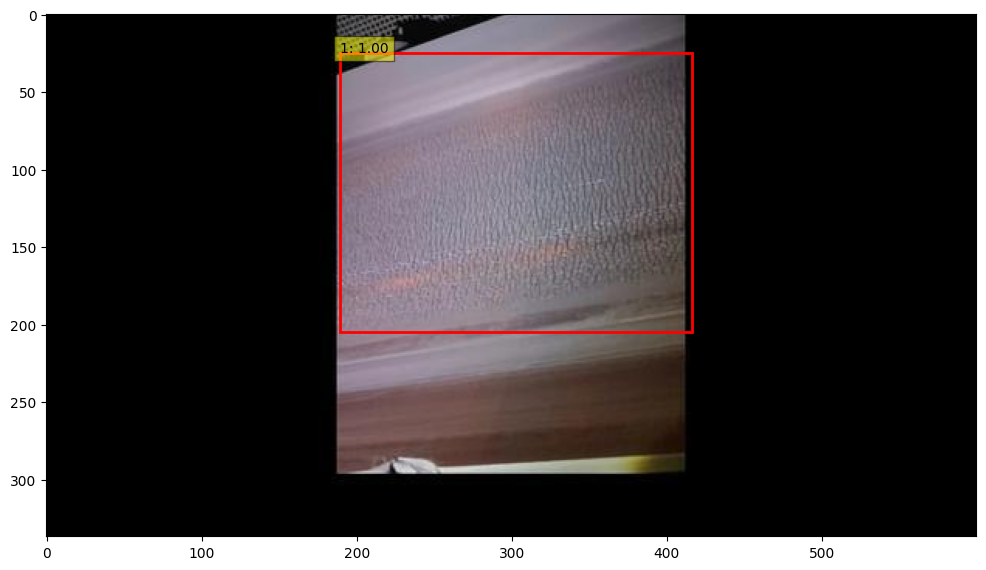

In [22]:
# Проверяем модель
evaluate_model(model, data_loader_test)

Модель-детектор расширяет возможности диагностики транспортерной ленты, позволяя не только выявлять неисправности, но и оценивать их масштаб. Например, рассчитывая площадь выявленных повреждений. Эта информация особенно актуальна для определения дальнейшей стратегии ремонта транспортерного оборудования. Применение данной модели оправдано для оборудования, установленного в местах с затрудненным для сервисного обслуживания расположением – стесненные условия, недостаточная высота потолков и прочие. Что позволяет полностью исключить диагностику специалистами сервисной службы.